# Notes



# Load Modules

In [1]:
import os
from optparse import Values

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import spearmanr, pearsonr
from scipy.spatial import Delaunay, distance

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

In [4]:
import anndata as ad

# Load data

In [ ]:
%%bash

# rsync -avcP ../../../STdata/merfish_mouse_cortex/cell_label_with_meta.csv.gz merfish_meta.csv
# rsync -avcP ../../../STdata/merfish_mouse_cortex/raw_data/counts.h5ad counts.h5ad


# selected samples

In [65]:
selected_samples = ['mouse2_slice99','mouse2_slice169', 'mouse1_slice301']

In [99]:
raw_counts = ad.read_h5ad('counts.h5ad')
raw_counts

AnnData object with n_obs × n_vars = 280186 × 254

In [ ]:
input_df = pd.read_csv('merfish_meta.csv', index_col=0)
input_df

In [97]:
nt_score_df = pd.read_csv('../../output/merfish_cortex_base_NT/NTScore.csv.gz', index_col=0)
nt_score_df.head()


,x,y,Niche_NTScore,Cell_NTScore
Cell_ID,,,,
10000143038275111136124942858811168393,4738.402723,3075.604074,0.398701,0.398146
100091152035772192874698518269494521268,4319.030049,2628.021401,0.601356,0.611682
100318785722691998123111916762029843183,4486.534300,2004.802524,0.802234,0.827713
100341059438931731510635049259352883335,4464.074801,3432.480751,0.506373,0.494413
101059342090754465645773829438399819266,4127.878468,2366.196146,0.801902,0.827421


In [ ]:
raw_counts.obs = raw_counts.obs.join(input_df)
raw_counts.obs = raw_counts.obs.join(nt_score_df[['Cell_NTScore']])
raw_counts.obs.head()

In [101]:
selected_adata = raw_counts[raw_counts.obs['slice_id'].isin(selected_samples)]
selected_adata

/sc/arion/work/wangw32/conda-env/envs/scverse/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


View of AnnData object with n_obs × n_vars = 14861 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'x', 'y', 'cortical_depth', 'extra_annot', 'leiden_res_10.00', 'leiden_res_30.00', 'Cell_NTScore'

In [102]:
selected_adata.X

ArrayView([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            1.41682005e+01, 2.08069440e-02, 4.88566905e-02],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            4.53515244e+00, 5.68433926e-02, 1.55052170e-01],
           [0.00000000e+00, 5.32006562e-01, 0.00000000e+00, ...,
            1.08872833e+01, 5.11860311e-01, 0.00000000e+00],
           ...,
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            2.93734223e-01, 0.00000000e+00, 4.81377482e-01],
           [0.00000000e+00, 6.62937105e-01, 0.00000000e+00, ...,
            8.31894779e+00, 0.00000000e+00, 1.25135668e-03],
           [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
            7.09483564e-01, 5.29562458e-02, 1.22337796e-01]],
          dtype=float32)

In [103]:
pd.DataFrame(selected_adata.X,
             index=[f'Cell_{i}' for i in range(selected_adata.X.shape[0])],
             columns=selected_adata.var_names).T.to_csv(
    'merfish_selected_exp.csv',
    index=True
)

In [104]:
selected_adata.obs.head()

,sample_id,slice_id,class_label,subclass,label,x,y,cortical_depth,extra_annot,leiden_res_10.00,leiden_res_30.00,Cell_NTScore
index,,,,,,,,,,,,
100058071267450629689866196035029399511,mouse2_sample6,mouse2_slice169,Glutamatergic,L5 ET,L5_ET_3,-3145.779407,3884.950901,667.210907,L5 ET,63,48,0.402788
100063495197968212990675334030574005996,mouse2_sample6,mouse2_slice169,Glutamatergic,L2/3 IT,L23_IT_4,-2972.356481,2558.893648,364.835270,L2/3 IT,14,171,0.783290
10006810796963211471780483969639718389,mouse2_sample5,mouse2_slice99,Glutamatergic,L4/5 IT,L45_IT_1,-100.569506,2776.927999,1094.584971,L4/5 IT,42,44,0.646011
10009720355034894926238975155842221990,mouse2_sample6,mouse2_slice169,Glutamatergic,L6 CT,L6_CT_2,-4048.311904,2090.110198,1270.628357,L6 CT,17,21,0.201171
100135247598137293514782974101948213300,mouse2_sample6,mouse2_slice169,Glutamatergic,L6 IT,L6_IT_3,-3849.190754,2475.294401,1151.161772,L6 IT,25,260,0.221022


In [133]:
selected_meta_df = selected_adata.obs[['subclass','x','y','slice_id','cortical_depth','Cell_NTScore','label']]
selected_meta_df.columns = ['Cell_Type','x','y','Sample','cortical_depth','Cell_NTScore','label']
selected_meta_df.index = [f'Cell_{i}' for i in range(selected_adata.X.shape[0])]
selected_meta_df.to_csv('merfish_selected_meta.csv', index=True, index_label='Cell_ID')

<Axes: xlabel='x', ylabel='y'>

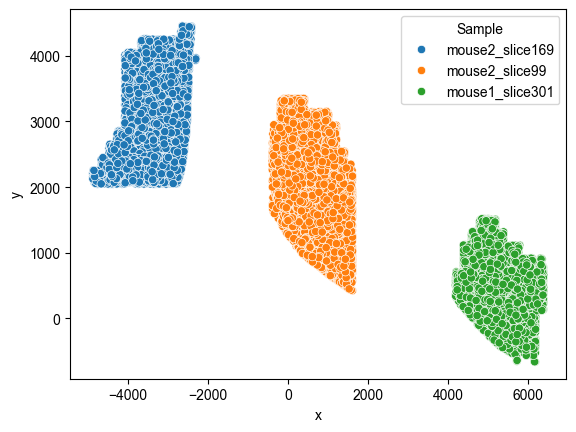

In [74]:
fig, ax = plt.subplots()
sns.scatterplot(data = selected_meta_df,
                x = 'x',
                y = 'y',
                hue = 'Sample',
                ax = ax)

# Gen pseudotime run lsf


- Our HPC using Load Sharing Facility (LSF) Job Scheduler, please modify the following code to fit your own computer.
- Please also modify the path for yourself

In [86]:
run_lsf_dir = '../../run_lsf'

os.makedirs(run_lsf_dir, exist_ok=True)

In [107]:
templete = '''#!/bin/bash
#BSUB -J {name}
#BSUB -n 12
#BSUB -P acc_YuanLab
#BSUB -q gpu
#BSUB -W 20:00
#BSUB -R "rusage[mem=10000] span[hosts=1]"
#BSUB -gpu num=1
#BSUB -R h100nvl

#BSUB -oo log/job_{name}.out
#BSUB -eo log/job_{name}.err

JOBID=$1

source /hpc/users/wangw32/.bash_profile

mkdir -p tasks/bench_marking/merfish_selected

conda activate seurat_v4
Rscript scripts/run_DPT_merfish.R raw_data/merfish_cortex/sce_selected_obj.rds tasks/bench_marking/merfish_selected
'''

In [108]:
name = 'merfish_selected_DPT'

with open(f'{run_lsf_dir}/{name}_run_lsf.sh', 'w') as f:
    f.write(templete.format(name=name))


In [89]:
templete = '''#!/bin/bash
#BSUB -J {name}
#BSUB -n 12
#BSUB -P acc_YuanLab
#BSUB -q gpu
#BSUB -W 20:00
#BSUB -R "rusage[mem=10000] span[hosts=1]"
#BSUB -gpu num=1
#BSUB -R h100nvl

#BSUB -oo log/job_{name}.out
#BSUB -eo log/job_{name}.err

JOBID=$1

source /hpc/users/wangw32/.bash_profile

mkdir -p tasks/bench_marking/merfish_selected

conda activate seurat_v4
Rscript scripts/run_monocle.R raw_data/merfish_cortex/cds_selected_obj.rds tasks/bench_marking/merfish_selected
'''

In [90]:
name = 'merfish_selected_monocle'

with open(f'{run_lsf_dir}/{name}_run_lsf.sh', 'w') as f:
    f.write(templete.format(name=name))

In [91]:
templete = '''#!/bin/bash
#BSUB -J {name}
#BSUB -n 12
#BSUB -P acc_YuanLab
#BSUB -q gpu
#BSUB -W 20:00
#BSUB -R "rusage[mem=10000] span[hosts=1]"
#BSUB -gpu num=1
#BSUB -R h100nvl

#BSUB -oo log/job_{name}.out
#BSUB -eo log/job_{name}.err

JOBID=$1

source /hpc/users/wangw32/.bash_profile

mkdir -p tasks/bench_marking/merfish_selected

conda activate seurat_v4
Rscript scripts/run_TSCAN.R raw_data/merfish_cortex/merfish_selected_exp.csv tasks/bench_marking/merfish_selected
'''

In [92]:
name = 'merfish_selected_tscan'

with open(f'{run_lsf_dir}/{name}_run_lsf.sh', 'w') as f:
    f.write(templete.format(name=name))

In [93]:
templete = '''#!/bin/bash
#BSUB -J {name}
#BSUB -n 12
#BSUB -P acc_YuanLab
#BSUB -q gpu
#BSUB -W 20:00
#BSUB -R "rusage[mem=10000] span[hosts=1]"
#BSUB -gpu num=1
#BSUB -R h100nvl

#BSUB -oo log/job_{name}.out
#BSUB -eo log/job_{name}.err

JOBID=$1

source /hpc/users/wangw32/.bash_profile

mkdir -p tasks/bench_marking/merfish_selected

conda activate spaceflow
python scripts/run_SpaceFlow.py raw_data/merfish_cortex/merfish_selected_exp.csv raw_data/merfish_cortex/merfish_selected_meta.csv tasks/bench_marking/merfish_selected
'''

In [94]:
name = 'merfish_selected_spaceFlow'

with open(f'{run_lsf_dir}/{name}_run_lsf.sh', 'w') as f:
    f.write(templete.format(name=name))

In [95]:
templete = '''#!/bin/bash
#BSUB -J {name}
#BSUB -n 12
#BSUB -P acc_YuanLab
#BSUB -q gpu
#BSUB -W 20:00
#BSUB -R "rusage[mem=100000] span[hosts=1]"
#BSUB -gpu num=1
#BSUB -R h100nvl

#BSUB -oo log/job_{name}.out
#BSUB -eo log/job_{name}.err

JOBID=$1

source /hpc/users/wangw32/.bash_profile

mkdir -p tasks/bench_marking/merfish_selected

conda activate spatialpca_env
Rscript scripts/run_spatialPCA.R raw_data/merfish_cortex/merfish_selected_exp.csv raw_data/merfish_cortex/merfish_selected_meta.csv tasks/bench_marking/merfish_selected
'''

In [96]:
name = 'merfish_selected_spatialPCA'

with open(f'{run_lsf_dir}/{name}_run_lsf.sh', 'w') as f:
    f.write(templete.format(name=name))

# benchmark results collect

In [115]:
from scipy.stats import spearmanr, pearsonr

In [106]:
selected_adata.obs.head()

,sample_id,slice_id,class_label,subclass,label,x,y,cortical_depth,extra_annot,leiden_res_10.00,leiden_res_30.00,Cell_NTScore
index,,,,,,,,,,,,
100058071267450629689866196035029399511,mouse2_sample6,mouse2_slice169,Glutamatergic,L5 ET,L5_ET_3,-3145.779407,3884.950901,667.210907,L5 ET,63,48,0.402788
100063495197968212990675334030574005996,mouse2_sample6,mouse2_slice169,Glutamatergic,L2/3 IT,L23_IT_4,-2972.356481,2558.893648,364.835270,L2/3 IT,14,171,0.783290
10006810796963211471780483969639718389,mouse2_sample5,mouse2_slice99,Glutamatergic,L4/5 IT,L45_IT_1,-100.569506,2776.927999,1094.584971,L4/5 IT,42,44,0.646011
10009720355034894926238975155842221990,mouse2_sample6,mouse2_slice169,Glutamatergic,L6 CT,L6_CT_2,-4048.311904,2090.110198,1270.628357,L6 CT,17,21,0.201171
100135247598137293514782974101948213300,mouse2_sample6,mouse2_slice169,Glutamatergic,L6 IT,L6_IT_3,-3849.190754,2475.294401,1151.161772,L6 IT,25,260,0.221022


In [113]:
spaceFlow_results = pd.read_csv('../../tasks/bench_marking/merfish_selected/pSM_values.tsv',
                                header=None)
spaceFlow_results.head()


,0
0,0.31968
1,0.89710
2,0.79635
3,0.12418
4,0.09127


In [114]:
spatialPCS_results = pd.read_csv('../../tasks/bench_marking/merfish_selected/spatial_pca.csv')
spatialPCS_results.head()


,Unnamed: 0,x
0,1,10.889199
1,2,NaN
2,3,7.772159
3,4,13.464537
4,5,13.682230


In [109]:
dpt_results = pd.read_csv('../../tasks/bench_marking/merfish_selected/DPT.csv')
dpt_results.head()


,Unnamed: 0,sim_time,dpt_norm
0,Cell_0,667.210907,0.985734
1,Cell_1,364.835270,0.489502
2,Cell_2,1094.584971,0.729879
3,Cell_3,1270.628357,0.903365
4,Cell_4,1151.161772,0.510498


In [110]:
monocle_results = pd.read_csv('../../tasks/bench_marking/merfish_selected/monocle.csv')
monocle_results.head()


,Unnamed: 0,sim_time,Size_Factor,monocle3_norm
0,Cell_0,667.210907,2.020660,0.391050
1,Cell_1,364.835270,0.597277,0.431157
2,Cell_2,1094.584971,1.613425,0.679273
3,Cell_3,1270.628357,1.314786,0.353567
4,Cell_4,1151.161772,1.958605,0.857806


In [111]:
tscan_results = pd.read_csv('../../tasks/bench_marking/merfish_selected/tscan.csv')
tscan_results.head()


,Unnamed: 0,tscan_norm
0,Cell_0,0.674950
1,Cell_1,NaN
2,Cell_2,NaN
3,Cell_3,0.874988
4,Cell_4,0.867696


In [119]:
selected_adata.obs['SpaceFlow_res'] = spaceFlow_results.iloc[:,0].values
selected_adata.obs['SptialPCA_res'] = spatialPCS_results['x'].values
selected_adata.obs['DPT_res'] = dpt_results['dpt_norm'].values
selected_adata.obs['Monocle_res'] = monocle_results['monocle3_norm'].values
selected_adata.obs['TSCAN_res'] = tscan_results['tscan_norm'].values


In [120]:
selected_adata.obs.head()

,sample_id,slice_id,class_label,subclass,label,x,y,cortical_depth,extra_annot,leiden_res_10.00,leiden_res_30.00,Cell_NTScore,SpaceFlow_res,SptialPCA_res,DPT_res,Monocle_res,TSCAN_res
index,,,,,,,,,,,,,,,,,
100058071267450629689866196035029399511,mouse2_sample6,mouse2_slice169,Glutamatergic,L5 ET,L5_ET_3,-3145.779407,3884.950901,667.210907,L5 ET,63,48,0.402788,0.31968,10.889199,0.985734,0.391050,0.674950
100063495197968212990675334030574005996,mouse2_sample6,mouse2_slice169,Glutamatergic,L2/3 IT,L23_IT_4,-2972.356481,2558.893648,364.835270,L2/3 IT,14,171,0.783290,0.89710,NaN,0.489502,0.431157,NaN
10006810796963211471780483969639718389,mouse2_sample5,mouse2_slice99,Glutamatergic,L4/5 IT,L45_IT_1,-100.569506,2776.927999,1094.584971,L4/5 IT,42,44,0.646011,0.79635,7.772159,0.729879,0.679273,NaN
10009720355034894926238975155842221990,mouse2_sample6,mouse2_slice169,Glutamatergic,L6 CT,L6_CT_2,-4048.311904,2090.110198,1270.628357,L6 CT,17,21,0.201171,0.12418,13.464537,0.903365,0.353567,0.874988
100135247598137293514782974101948213300,mouse2_sample6,mouse2_slice169,Glutamatergic,L6 IT,L6_IT_3,-3849.190754,2475.294401,1151.161772,L6 IT,25,260,0.221022,0.09127,13.682230,0.510498,0.857806,0.867696


In [123]:
def gen_res():
    for sample in selected_adata.obs['slice_id'].unique():
        sample_df = selected_adata.obs[selected_adata.obs['slice_id'] == sample]
        yield sample, 'ONTraC', abs(spearmanr(sample_df['cortical_depth'], sample_df['Cell_NTScore'], nan_policy='omit')[0])
        yield sample, 'SpaceFlow', abs(spearmanr(sample_df['cortical_depth'], sample_df['SpaceFlow_res'], nan_policy='omit')[0])
        yield sample, 'SpatialPCA', abs(spearmanr(sample_df['cortical_depth'], sample_df['SptialPCA_res'], nan_policy='omit')[0])
        yield sample, 'DPT', abs(spearmanr(sample_df['cortical_depth'], sample_df['DPT_res'], nan_policy='omit')[0])
        yield sample, 'Monocle', abs(spearmanr(sample_df['cortical_depth'], sample_df['Monocle_res'], nan_policy='omit')[0])
        yield sample, 'TSCAN', abs(spearmanr(sample_df['cortical_depth'], sample_df['TSCAN_res'], nan_policy='omit')[0])
            

            
results_df = pd.DataFrame(gen_res(), columns = ['sample', 'method', 'corr'])
results_df.head()

,sample,method,corr
0,mouse2_slice169,ONTraC,0.973321
1,mouse2_slice169,SpaceFlow,0.678586
2,mouse2_slice169,SpatialPCA,0.936065
3,mouse2_slice169,DPT,0.139788
4,mouse2_slice169,Monocle,0.119603


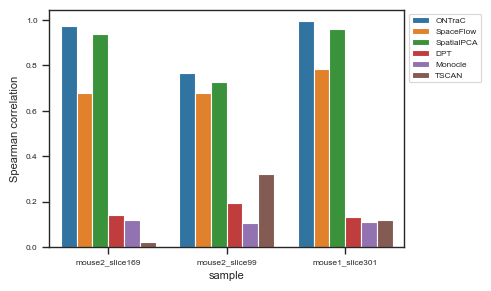

In [132]:
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 8,
                             'axes.labelsize': 8,
                             'xtick.labelsize': 6,
                             'ytick.labelsize': 6,
                             'legend.fontsize': 6
                         }):
    fig, ax = plt.subplots(figsize=(5,3))
    sns.barplot(
        results_df,
        x = 'sample',
        y = 'corr',
        hue = 'method',
        ax = ax
    )
    ax.legend(loc="upper left", bbox_to_anchor=(1,1))
    ax.set_ylabel('Spearman correlation')
    fig.tight_layout()
    fig.savefig('merfish_selected_benchmark.pdf', transparent=True)